# Visualize attention maps
https://github.com/huggingface/pytorch-image-models/discussions/1232

In [18]:
import os
import sys

import torch
import torch.nn.functional as F
import numpy as np
import cv2

import wandb
import matplotlib.pyplot as plt

# To add src to the path so that we can import modules
current_directory = os.getcwd()
if not current_directory.endswith("emotion_recognition"):
    sys.path.append(os.path.join(current_directory, 'emotion_recognition'))

try:
    from src import RAW_AFFECTNET_DIR, MODELS_DIR
    import src.models.architectures as arch
    from src.data.dataset import data_transforms
    from config import wandbAPIkey
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)


In [19]:
def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(2, 2))
    plt.imshow(img, cmap='magma')
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(2, 2))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha, cmap='magma')
    plt.axis('off')
    plt.show()

def attention_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

Get model from wandb

In [20]:
wandb.login(key=wandbAPIkey)
api = wandb.Api()
artifact_dir = arch.get_wandb_artifact("comic-sweep-22", api = api)
local_artifact = torch.load(os.path.join(artifact_dir, "model_best.pt"))
params = local_artifact["params"]
emotion_model, device = arch.model_creation(params['arch'], local_artifact['state_dict'])
emotion_model.eval()
# Load the face transforms
face_transforms = data_transforms(only_normalize = True, image_norm = params['image_norm'], resize = True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


wandb: Appending key for api.wandb.ai to your netrc file: /home/usuaris/imatge/armand.de.asis/.netrc


Using trained model: comic-sweep-22


wandb:   2 of 2 files downloaded.  


Artifact downloaded to: /home/usuaris/imatge/armand.de.asis/artifacts/model_comic-sweep-22:v0
Using CUDA with 1 GPUs
Using CUDA device:NVIDIA GeForce GTX 1080 Ti
Creating model with architecture: deit_tiny
Using imagenet pre-trained weights: False
Using custom weights of type <class 'collections.OrderedDict'>: 


Load image from test.

In [21]:
val_path = os.path.join(RAW_AFFECTNET_DIR, "val_set")
val_path_annotation = os.path.join(val_path, "annotations")
val_path_images = os.path.join(val_path, "images")

selected_id = 10
image_filename = [img for img in os.listdir(val_path_images) if img.split('.')[0] == str(selected_id)][0]
image_path = os.path.join(val_path_images, image_filename)
print(image_path)
img = cv2.imread(image_path)                    # In BGR format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # Convert from BGR to RGB
img_inference = face_transforms(image=img)["image"].unsqueeze(0).to(device)

/mnt/gpid08/datasets/affectnet/raw/val_set/images/10.jpg


(tensor([[ 1.5373, -0.7109, -0.4275, -1.8072, -2.2971, -1.1172,  0.5517,  1.6574]],
       device='cuda:0'), tensor([[ 1.3549, -0.7317,  0.1852, -1.3309, -2.3365, -1.2439,  0.9941,  1.6192]],
       device='cuda:0'))
torch.Size([198, 198])
torch.Size([14, 14])
torch.Size([224, 224, 1])


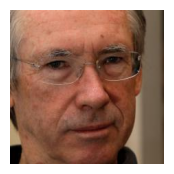

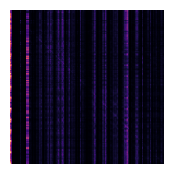

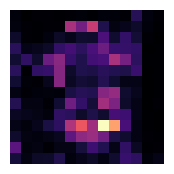

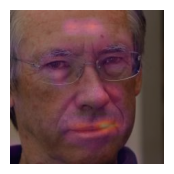

In [25]:
selected_layer = 11
emotion_model.base_model.blocks[selected_layer].attn.forward = attention_forward_wrapper(emotion_model.base_model.blocks[selected_layer].attn)

with torch.no_grad():
    y = emotion_model(img_inference)
    print(y)
attn_map = emotion_model.base_model.blocks[selected_layer].attn.attn_map.mean(dim=1).squeeze(0).detach().to('cpu')
cls_weight = emotion_model.base_model.blocks[selected_layer].attn.cls_attn_map.mean(dim=1).view(14, 14).detach().to('cpu')
print(attn_map.shape) # attention map for last layer (198 x 198 (=196(14x14 img) + 1(cls) + 1(distill)))
print(cls_weight.shape) 

cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
print(cls_resized.shape)

show_img(img)
show_img(attn_map) 
show_img(cls_weight)
show_img2(img, cls_resized, alpha=0.35)